Epoch 1/50


C:\Users\admin\AppData\Local\Temp\ipykernel_13740\325720765.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['revenue'].resample('M').sum().to_frame()
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3883
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2826
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1523
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0633
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0539
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0657
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0697
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0309
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0325
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0528
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0364
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0452
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0402
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0374 
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

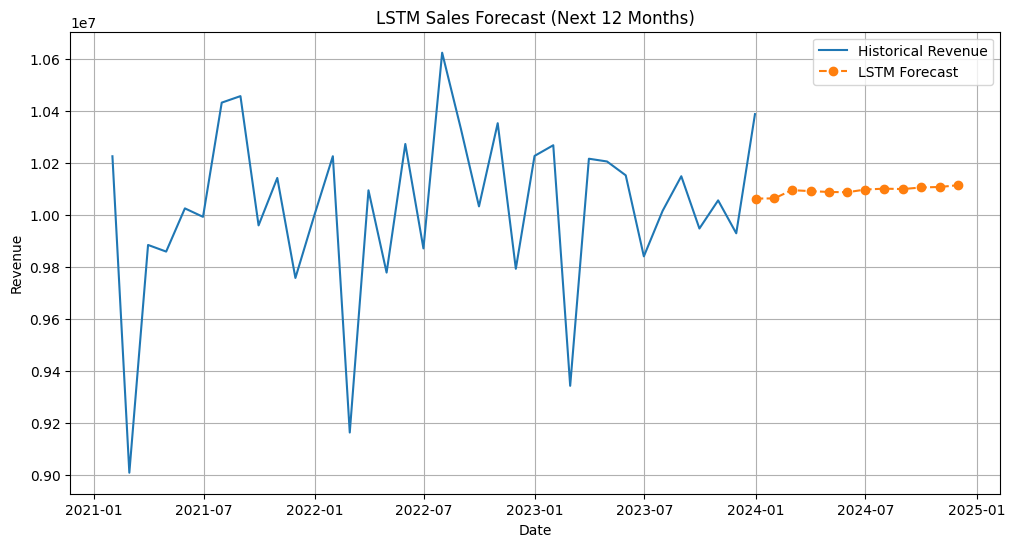

In [2]:
# 05_model_building_LSTM.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import joblib

# Step 1: Load and prepare data
df = pd.read_csv('../data/cleaned_sales_data.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
monthly = df['revenue'].resample('M').sum().to_frame()

# Step 2: Normalize data
scaler = MinMaxScaler()
monthly['scaled_revenue'] = scaler.fit_transform(monthly[['revenue']])

# Step 3: Prepare data for LSTM
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
values = monthly['scaled_revenue'].values
X, y = create_sequences(values, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 4: Build LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

# Step 5: Save model and scaler
model.save('../models/lstm_model.h5')
joblib.dump(scaler, '../models/lstm_scaler.save')

# Step 6: Forecast next 12 months
pred_input = values[-sequence_length:]
future_preds = []

for _ in range(12):
    input_seq = pred_input[-sequence_length:].reshape(1, sequence_length, 1)
    pred = model.predict(input_seq, verbose=0)
    future_preds.append(pred[0][0])
    pred_input = np.append(pred_input, pred[0][0])

# Inverse transform to original scale
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Step 7: Plot forecast
future_dates = pd.date_range(monthly.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_df = pd.DataFrame({'Forecast': future_preds.flatten()}, index=future_dates)

plt.figure(figsize=(12,6))
plt.plot(monthly['revenue'], label='Historical Revenue')
plt.plot(forecast_df, label='LSTM Forecast', linestyle='--', marker='o')
plt.title('LSTM Sales Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.savefig('../images/lstm_forecast.png')
plt.show()
